<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/MLP/MLP_Corn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 150 (delta 73), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (150/150), 121.14 KiB | 821.00 KiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Fri Jul 23 10:37:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Corn'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'MLP'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 3.9 MB/s 
     |████████████████████████████████| 97 kB 5.6 MB/s 
     |████████████████████████████████| 177 kB 17.3 MB/s 
     |████████████████████████████████| 138 kB 18.3 MB/s 
     |████████████████████████████████| 133 kB 17.9 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 
     |████████████████████████████████| 62 kB 1.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop', 'sgd']
        },
        'activation': {
            'values': ['relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(Dense(256, activation=config.activation, input_shape=(window_len, 1)))
    # layer 2
    model.add(Dense(128, activation=config.activation))
    # layer 3
    model.add(Dense(64, activation=config.activation))
    # layer 4
    model.add(Dense(32, activation=config.activation))
    # layer 5
    model.add(Flatten())
    # layer 6
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: mmafq4jo
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_MLP/sweeps/mmafq4jo


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: lafelrlo with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/200
8/8 [==============================] - 14s 85ms/step - loss: 1.9620 - mean_squared_error: 1.9620 - mean_absolute_error: 1.0293 - val_loss: 0.1102 - val_mean_squared_error: 0.1102 - val_mean_absolute_error: 0.2581
Epoch 2/200
8/8 [==============================] - 0s 7ms/step - loss: 0.3495 - mean_squared_error: 0.3495 - mean_absolute_error: 0.4878 - val_loss: 0.4445 - val_mean_squared_error: 0.4445 - val_mean_absolute_error: 0.6227
Epoch 3/200
8/8 [==============================] - 0s 8ms/step - loss: 0.1417 - mean_squared_error: 0.1417 - mean_absolute_error: 0.3071 - val_loss: 0.0780 - val_mean_squared_error: 0.0780 - val_mean_absolute_error: 0.2227
Epoch 4/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0292 - mean_squared_error: 0.0292 - mean_absolute_error: 0.1430 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1157
Epoch 5/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0063 - mean_squared_error: 0.0063

epoch,54
loss,0.00065
mean_squared_error,0.00065
mean_absolute_error,0.01938
val_loss,0.00492
val_mean_squared_error,0.00492
val_mean_absolute_error,0.0523
_runtime,25
_timestamp,1627036682
_step,54
best_val_loss,0.00455


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▃█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▄█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆████████
_timestamp,▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆████████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ibkp72gi with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 2s 60ms/step - loss: 0.1218 - mean_squared_error: 0.1218 - mean_absolute_error: 0.2542 - val_loss: 0.0670 - val_mean_squared_error: 0.0670 - val_mean_absolute_error: 0.1816
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0200 - mean_squared_error: 0.0200 - mean_absolute_error: 0.1121 - val_loss: 0.0259 - val_mean_squared_error: 0.0259 - val_mean_absolute_error: 0.1271
Epoch 3/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0798 - val_loss: 0.0311 - val_mean_squared_error: 0.0311 - val_mean_absolute_error: 0.1368
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0105 - mean_squared_error: 0.0105 - mean_absolute_error: 0.0846 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.1012
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mea

epoch,49
loss,0.00152
mean_squared_error,0.00152
mean_absolute_error,0.03003
val_loss,0.0063
val_mean_squared_error,0.0063
val_mean_absolute_error,0.059
_runtime,10
_timestamp,1627036704
_step,49
best_val_loss,0.0063


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▂▃▂▁▂▃▁▁▁▂▂▂▁▂▁▁▁▁▂▁▁▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁
val_loss,█▃▄▂▃▂▂▂▃▂▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▄▂▃▂▂▂▃▂▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▃▄▃▃▃▅▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▂▁▁▁▂▂▁▁▁▁▂▁
_runtime,▁▂▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 3mk64m6b with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 2s 33ms/step - loss: 1.7556 - mean_squared_error: 1.7556 - mean_absolute_error: 0.8508 - val_loss: 0.0267 - val_mean_squared_error: 0.0267 - val_mean_absolute_error: 0.1252
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0167 - mean_squared_error: 0.0167 - mean_absolute_error: 0.1030 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.1024
Epoch 3/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0495 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0777
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0319 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0736
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0015 - mean_squared_erro

epoch,30
loss,0.00094
mean_squared_error,0.00094
mean_absolute_error,0.02343
val_loss,0.00596
val_mean_squared_error,0.00596
val_mean_absolute_error,0.05886
_runtime,9
_timestamp,1627036724
_step,30
best_val_loss,0.00471


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▂▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▃▃▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▂▁▂▂▁▁▁▂
_runtime,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆████████
_timestamp,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆████████
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: 9tudqpjq with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 2s 59ms/step - loss: 0.1220 - mean_squared_error: 0.1220 - mean_absolute_error: 0.3021 - val_loss: 0.1065 - val_mean_squared_error: 0.1065 - val_mean_absolute_error: 0.2779
Epoch 2/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0325 - mean_squared_error: 0.0325 - mean_absolute_error: 0.1350 - val_loss: 0.0328 - val_mean_squared_error: 0.0328 - val_mean_absolute_error: 0.1466
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0739 - val_loss: 0.0320 - val_mean_squared_error: 0.0320 - val_mean_absolute_error: 0.1455
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0607 - val_loss: 0.0313 - val_mean_squared_error: 0.0313 - val_mean_absolute_error: 0.1449
Epoch 5/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0065 - mean_squared_error: 0.0065 

epoch,199
loss,0.00076
mean_squared_error,0.00076
mean_absolute_error,0.02051
val_loss,0.00531
val_mean_squared_error,0.00531
val_mean_absolute_error,0.05379
_runtime,25
_timestamp,1627036761
_step,199
best_val_loss,0.00531


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▂▂▂▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: v6tlqthb with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 2s 61ms/step - loss: 0.1534 - mean_squared_error: 0.1534 - mean_absolute_error: 0.2724 - val_loss: 0.0374 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1480
Epoch 2/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0156 - mean_squared_error: 0.0156 - mean_absolute_error: 0.1006 - val_loss: 0.0248 - val_mean_squared_error: 0.0248 - val_mean_absolute_error: 0.1229
Epoch 3/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0699 - val_loss: 0.0295 - val_mean_squared_error: 0.0295 - val_mean_absolute_error: 0.1312
Epoch 4/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0773 - val_loss: 0.0208 - val_mean_squared_error: 0.0208 - val_mean_absolute_error: 0.1132
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0066 - mean_squared_error: 0.0066 

epoch,79
loss,0.00081
mean_squared_error,0.00081
mean_absolute_error,0.02177
val_loss,0.00592
val_mean_squared_error,0.00592
val_mean_absolute_error,0.05841
_runtime,13
_timestamp,1627036785
_step,79
best_val_loss,0.00585


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▃▂▁▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▂▃▂▂▃▂▂▂▂▂▁▂▂▁▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▂▃▂▂▃▂▂▂▂▂▁▂▂▁▁▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▃▃▃▃▅▃▃▃▂▂▂▂▂▂▂▂▁▁▂▃▂▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: zms6n2kx with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
31/31 [==============================] - 1s 18ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 2/50
31/31 [==============================] - 0s 5ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 3/50
31/31 [==============================] - 0s 5ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 5/50
31/31 [==============================] - 0s 5ms/step - loss: nan - mean_squared_error: nan - mean_absolute_error: nan - val_loss: nan - val_mean_squared_error: nan 

epoch,9
loss,nan
mean_squared_error,nan
mean_absolute_error,nan
val_loss,nan
val_mean_squared_error,nan
val_mean_absolute_error,nan
_runtime,7
_timestamp,1627036804
_step,9


epoch,▁▂▃▃▄▅▆▆▇█
loss,
mean_squared_error,
mean_absolute_error,
val_loss,
val_mean_squared_error,
val_mean_absolute_error,
_runtime,▁▁▁▅▅▅▅▅▅█
_timestamp,▁▁▁▅▅▅▅▅▅█
_step,▁▂▃▃▄▅▆▆▇█


wandb: Agent Starting Run: lfhv1zim with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
31/31 [==============================] - 1s 18ms/step - loss: 0.1465 - mean_squared_error: 0.1465 - mean_absolute_error: 0.3337 - val_loss: 0.1484 - val_mean_squared_error: 0.1484 - val_mean_absolute_error: 0.3235
Epoch 2/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0554 - mean_squared_error: 0.0554 - mean_absolute_error: 0.1684 - val_loss: 0.0737 - val_mean_squared_error: 0.0737 - val_mean_absolute_error: 0.2177
Epoch 3/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0288 - mean_squared_error: 0.0288 - mean_absolute_error: 0.1075 - val_loss: 0.0568 - val_mean_squared_error: 0.0568 - val_mean_absolute_error: 0.1892
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0244 - mean_squared_error: 0.0244 - mean_absolute_error: 0.1102 - val_loss: 0.0553 - val_mean_squared_error: 0.0553 - val_mean_absolute_error: 0.1872
Epoch 5/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0233 - mean_squared_error: 0.

epoch,49
loss,0.00538
mean_squared_error,0.00538
mean_absolute_error,0.05396
val_loss,0.0299
val_mean_squared_error,0.0299
val_mean_absolute_error,0.14117
_runtime,15
_timestamp,1627036832
_step,49
best_val_loss,0.0299


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: f5j9xtj9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 2s 62ms/step - loss: 0.1128 - mean_squared_error: 0.1128 - mean_absolute_error: 0.2821 - val_loss: 0.0410 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1696
Epoch 2/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0766 - val_loss: 0.0394 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1685
Epoch 3/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0632 - val_loss: 0.0330 - val_mean_squared_error: 0.0330 - val_mean_absolute_error: 0.1427
Epoch 4/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0604 - val_loss: 0.0296 - val_mean_squared_error: 0.0296 - val_mean_absolute_error: 0.1357
Epoch 5/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0055 - mean_squared_error: 0.005

epoch,116
loss,0.00205
mean_squared_error,0.00205
mean_absolute_error,0.03691
val_loss,0.00629
val_mean_squared_error,0.00629
val_mean_absolute_error,0.06012
_runtime,17
_timestamp,1627036861
_step,116
best_val_loss,0.00616


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂
val_loss,█▆▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▃▃▃▂▂▂▂▂▂▂▂▃▂▂▂▂▂▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 93v7lrij with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 1s 31ms/step - loss: 0.1318 - mean_squared_error: 0.1318 - mean_absolute_error: 0.3195 - val_loss: 0.1583 - val_mean_squared_error: 0.1583 - val_mean_absolute_error: 0.3377
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0608 - mean_squared_error: 0.0608 - mean_absolute_error: 0.1845 - val_loss: 0.0726 - val_mean_squared_error: 0.0726 - val_mean_absolute_error: 0.2171
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0269 - mean_squared_error: 0.0269 - mean_absolute_error: 0.1068 - val_loss: 0.0511 - val_mean_squared_error: 0.0511 - val_mean_absolute_error: 0.1788
Epoch 4/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0273 - mean_squared_error: 0.0273 - mean_absolute_error: 0.1240 - val_loss: 0.0524 - val_mean_squared_error: 0.0524 - val_mean_absolute_error: 0.1821
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0233 - mean_squared_erro

epoch,99
loss,0.00346
mean_squared_error,0.00346
mean_absolute_error,0.04342
val_loss,0.02085
val_mean_squared_error,0.02085
val_mean_absolute_error,0.11842
_runtime,19
_timestamp,1627036900
_step,99
best_val_loss,0.02085


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: pfbkmnx7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 2s 59ms/step - loss: 0.0576 - mean_squared_error: 0.0576 - mean_absolute_error: 0.1790 - val_loss: 0.0356 - val_mean_squared_error: 0.0356 - val_mean_absolute_error: 0.1593
Epoch 2/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0625 - val_loss: 0.0292 - val_mean_squared_error: 0.0292 - val_mean_absolute_error: 0.1350
Epoch 3/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0640 - val_loss: 0.0275 - val_mean_squared_error: 0.0275 - val_mean_absolute_error: 0.1319
Epoch 4/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0625 - val_loss: 0.0259 - val_mean_squared_error: 0.0259 - val_mean_absolute_error: 0.1315
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0046 - mean_squared_error: 0.0046 

epoch,49
loss,0.00215
mean_squared_error,0.00215
mean_absolute_error,0.03527
val_loss,0.00892
val_mean_squared_error,0.00892
val_mean_absolute_error,0.07363
_runtime,11
_timestamp,1627036930
_step,49
best_val_loss,0.0088


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▂
val_loss,█▆▆▅▅▄▅▃▂▂▃▂▂▂▂▂▃▁▂▁▁▃▁▂▂▂▁▁▁▂▁▁▂▁▁▁▂▁▁▁
val_mean_squared_error,█▆▆▅▅▄▅▃▂▂▃▂▂▂▂▂▃▁▂▁▁▃▁▂▂▂▁▁▁▂▁▁▂▁▁▁▂▁▁▁
val_mean_absolute_error,█▆▆▆▅▅▆▄▃▃▃▂▂▂▃▃▃▂▂▁▁▃▁▂▂▂▁▁▁▂▁▁▃▁▁▁▂▁▁▁
_runtime,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆█
_timestamp,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 78im5og6 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/200
31/31 [==============================] - 1s 17ms/step - loss: 0.0334 - mean_squared_error: 0.0334 - mean_absolute_error: 0.1304 - val_loss: 0.0232 - val_mean_squared_error: 0.0232 - val_mean_absolute_error: 0.1227
Epoch 2/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0421 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1095
Epoch 3/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0361 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0938
Epoch 4/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0315 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0863
Epoch 5/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0015 - mean_squared_erro

epoch,144
loss,0.00061
mean_squared_error,0.00061
mean_absolute_error,0.01849
val_loss,0.00487
val_mean_squared_error,0.00487
val_mean_absolute_error,0.05257
_runtime,32
_timestamp,1627036977
_step,144
best_val_loss,0.00487


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: od1qmwzm with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 2s 31ms/step - loss: 0.2420 - mean_squared_error: 0.2420 - mean_absolute_error: 0.2458 - val_loss: 0.0201 - val_mean_squared_error: 0.0201 - val_mean_absolute_error: 0.1164
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0178 - mean_squared_error: 0.0178 - mean_absolute_error: 0.0922 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.1066
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0201 - mean_squared_error: 0.0201 - mean_absolute_error: 0.0931 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1155
Epoch 4/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0864 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.1009
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0090 - mean_squared_erro

epoch,42
loss,0.00131
mean_squared_error,0.00131
mean_absolute_error,0.0273
val_loss,0.00822
val_mean_squared_error,0.00822
val_mean_absolute_error,0.07349
_runtime,11
_timestamp,1627037003
_step,42
best_val_loss,0.00572


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▅▄▃▃▃▃▂▃▁▂▂▂▂▂▂▁▂▂▂▂▂▁▂▂▁▂▁▂▂▁▁▁▁▂▁▁▁
val_loss,▂▂▂▂▂█▂▁▁▂▂▃▁▁▂▁▂▁▂▁▁▂▁▁▁▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁
val_mean_squared_error,▂▂▂▂▂█▂▁▁▂▂▃▁▁▂▁▂▁▂▁▁▂▁▁▁▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁
val_mean_absolute_error,▃▃▃▃▃█▃▂▂▂▂▄▁▁▃▁▂▁▂▁▁▂▂▁▂▂▁▂▁▂▁▁▃▁▂▁▁▁▂▂
_runtime,▁▁▁▁▂▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██


wandb: Agent Starting Run: vmd0fms8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 2s 66ms/step - loss: 0.1095 - mean_squared_error: 0.1095 - mean_absolute_error: 0.2866 - val_loss: 0.1040 - val_mean_squared_error: 0.1040 - val_mean_absolute_error: 0.2781
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0258 - mean_squared_error: 0.0258 - mean_absolute_error: 0.1199 - val_loss: 0.0473 - val_mean_squared_error: 0.0473 - val_mean_absolute_error: 0.1768
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0791 - val_loss: 0.0468 - val_mean_squared_error: 0.0468 - val_mean_absolute_error: 0.1783
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - mean_absolute_error: 0.0727 - val_loss: 0.0453 - val_mean_squared_error: 0.0453 - val_mean_absolute_error: 0.1760
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0082 - mean_squared_error: 0.0082 

epoch,99
loss,0.00102
mean_squared_error,0.00102
mean_absolute_error,0.02404
val_loss,0.00682
val_mean_squared_error,0.00682
val_mean_absolute_error,0.06255
_runtime,18
_timestamp,1627037034
_step,99
best_val_loss,0.00682


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: j05qvu0x with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
31/31 [==============================] - 2s 18ms/step - loss: 0.6435 - mean_squared_error: 0.6435 - mean_absolute_error: 0.6096 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1190
Epoch 2/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0598 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0834
Epoch 3/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0312 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0830
Epoch 4/200
31/31 [==============================] - 0s 7ms/step - loss: 0.2788 - mean_squared_error: 0.2788 - mean_absolute_error: 0.2302 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1185
Epoch 5/200
31/31 [==============================] - 0s 7ms/step - loss: 0.2723 - mean_squared_erro

epoch,31
loss,0.00108
mean_squared_error,0.00108
mean_absolute_error,0.02436
val_loss,0.00589
val_mean_squared_error,0.00589
val_mean_absolute_error,0.05736
_runtime,15
_timestamp,1627037062
_step,31
best_val_loss,0.00519


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▃▁▁▁▁▁▁
mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▃▁▁▁▁▁▁
mean_absolute_error,▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▅▂▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁
val_mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁
val_mean_absolute_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▃▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: h8g6tzt2 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 2s 19ms/step - loss: 0.1222 - mean_squared_error: 0.1222 - mean_absolute_error: 0.2839 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.1018
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0429 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0811
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0461 - val_loss: 0.0094 - val_mean_squared_error: 0.0094 - val_mean_absolute_error: 0.0769
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0350 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0786
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0013 - mean_squared_erro

epoch,34
loss,0.00083
mean_squared_error,0.00083
mean_absolute_error,0.02162
val_loss,0.00563
val_mean_squared_error,0.00563
val_mean_absolute_error,0.05541
_runtime,15
_timestamp,1627037090
_step,34
best_val_loss,0.00494


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▅▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▅▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▅▁▁▁▁▁▁▁▁
val_loss,▅▃▃▃▃▂▂▂▃▁▁▂▁▁▁▁▃▁▁▁▂▁▁▁▁█▂▂▁▁▁▁▁▁▁
val_mean_squared_error,▅▃▃▃▃▂▂▂▃▁▁▂▁▁▁▁▃▁▁▁▂▁▁▁▁█▂▂▁▁▁▁▁▁▁
val_mean_absolute_error,▆▄▃▄▃▂▂▂▄▂▂▂▂▂▂▁▄▁▁▁▃▂▂▁▁█▃▂▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 9ish153q with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/200
8/8 [==============================] - 2s 60ms/step - loss: 0.1294 - mean_squared_error: 0.1294 - mean_absolute_error: 0.2808 - val_loss: 0.0394 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1584
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0133 - mean_squared_error: 0.0133 - mean_absolute_error: 0.0901 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - val_mean_absolute_error: 0.1675
Epoch 3/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0642 - val_loss: 0.0354 - val_mean_squared_error: 0.0354 - val_mean_absolute_error: 0.1556
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0593 - val_loss: 0.0330 - val_mean_squared_error: 0.0330 - val_mean_absolute_error: 0.1507
Epoch 5/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0055 - mean_squared_error: 0.0055 

epoch,199
loss,0.00093
mean_squared_error,0.00093
mean_absolute_error,0.02287
val_loss,0.00816
val_mean_squared_error,0.00816
val_mean_absolute_error,0.06857
_runtime,26
_timestamp,1627037131
_step,199
best_val_loss,0.00815


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: o6m3p3qp with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 1s 62ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0765 - val_loss: 0.0390 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1627
Epoch 2/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0632 - val_loss: 0.0375 - val_mean_squared_error: 0.0375 - val_mean_absolute_error: 0.1597
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0626 - val_loss: 0.0361 - val_mean_squared_error: 0.0361 - val_mean_absolute_error: 0.1567
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0602 - val_loss: 0.0348 - val_mean_squared_error: 0.0348 - val_mean_absolute_error: 0.1542
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - me

epoch,49
loss,0.00266
mean_squared_error,0.00266
mean_absolute_error,0.03849
val_loss,0.01777
val_mean_squared_error,0.01777
val_mean_absolute_error,0.10711
_runtime,12
_timestamp,1627037157
_step,49
best_val_loss,0.0176


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▆▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▆▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▇▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▇▇▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ta55ebq8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/200
31/31 [==============================] - 2s 20ms/step - loss: 0.1300 - mean_squared_error: 0.1300 - mean_absolute_error: 0.3075 - val_loss: 0.0840 - val_mean_squared_error: 0.0840 - val_mean_absolute_error: 0.2373
Epoch 2/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0299 - mean_squared_error: 0.0299 - mean_absolute_error: 0.1147 - val_loss: 0.0544 - val_mean_squared_error: 0.0544 - val_mean_absolute_error: 0.1869
Epoch 3/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0258 - mean_squared_error: 0.0258 - mean_absolute_error: 0.1167 - val_loss: 0.0569 - val_mean_squared_error: 0.0569 - val_mean_absolute_error: 0.1933
Epoch 4/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0234 - mean_squared_error: 0.0234 - mean_absolute_error: 0.1079 - val_loss: 0.0539 - val_mean_squared_error: 0.0539 - val_mean_absolute_error: 0.1882
Epoch 5/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0212 - mean_squared_erro

epoch,199
loss,0.00147
mean_squared_error,0.00147
mean_absolute_error,0.02859
val_loss,0.01151
val_mean_squared_error,0.01151
val_mean_absolute_error,0.08493
_runtime,50
_timestamp,1627037221
_step,199
best_val_loss,0.01151


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: qpnru9gr with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 2s 31ms/step - loss: 0.0949 - mean_squared_error: 0.0949 - mean_absolute_error: 0.2453 - val_loss: 0.0350 - val_mean_squared_error: 0.0350 - val_mean_absolute_error: 0.1525
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0728 - val_loss: 0.0325 - val_mean_squared_error: 0.0325 - val_mean_absolute_error: 0.1460
Epoch 3/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0587 - val_loss: 0.0293 - val_mean_squared_error: 0.0293 - val_mean_absolute_error: 0.1407
Epoch 4/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0528 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.1344
Epoch 5/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0043 - mean_squared_error: 0.

epoch,49
loss,0.00085
mean_squared_error,0.00085
mean_absolute_error,0.02187
val_loss,0.00581
val_mean_squared_error,0.00581
val_mean_absolute_error,0.05793
_runtime,15
_timestamp,1627037250
_step,49
best_val_loss,0.0057


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▆▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▇▆▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▇▇▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 7u048nxy with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 2s 31ms/step - loss: 0.0534 - mean_squared_error: 0.0534 - mean_absolute_error: 0.1685 - val_loss: 0.0377 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1648
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0671 - val_loss: 0.0287 - val_mean_squared_error: 0.0287 - val_mean_absolute_error: 0.1294
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0660 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1150
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0502 - val_loss: 0.0220 - val_mean_squared_error: 0.0220 - val_mean_absolute_error: 0.1218
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0039 - mean_squared_error: 0.

epoch,49
loss,0.00246
mean_squared_error,0.00246
mean_absolute_error,0.03716
val_loss,0.00703
val_mean_squared_error,0.00703
val_mean_absolute_error,0.06337
_runtime,13
_timestamp,1627037278
_step,49
best_val_loss,0.00703


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▂▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▂▁▂▁▁▁▁▂
val_loss,█▆▄▄▃▃▃▂▃▂▂▃▂▂▂▂▂▅▁▂▁▂▂▁▂▁▁▁▂▁▄▁▁▁▁▂▁▁▃▁
val_mean_squared_error,█▆▄▄▃▃▃▂▃▂▂▃▂▂▂▂▂▅▁▂▁▂▂▁▂▁▁▁▂▁▄▁▁▁▁▂▁▁▃▁
val_mean_absolute_error,█▆▅▅▃▃▃▃▃▂▂▄▃▂▂▂▃▆▂▃▁▂▂▁▂▁▂▁▂▁▅▁▂▁▁▃▁▂▃▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███████
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: taxrl00t with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
31/31 [==============================] - 2s 19ms/step - loss: 0.0528 - mean_squared_error: 0.0528 - mean_absolute_error: 0.1676 - val_loss: 0.0371 - val_mean_squared_error: 0.0371 - val_mean_absolute_error: 0.1476
Epoch 2/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0641 - val_loss: 0.0292 - val_mean_squared_error: 0.0292 - val_mean_absolute_error: 0.1418
Epoch 3/200
31/31 [==============================] - 0s 8ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0482 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.1069
Epoch 4/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0365 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0979
Epoch 5/200
31/31 [==============================] - 0s 7ms/step - loss: 0.0030 - mean_squared_erro

epoch,91
loss,0.00074
mean_squared_error,0.00074
mean_absolute_error,0.02052
val_loss,0.00465
val_mean_squared_error,0.00465
val_mean_absolute_error,0.05064
_runtime,31
_timestamp,1627037324
_step,91
best_val_loss,0.00461


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▃▃▂▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: n9nsznfe with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
31/31 [==============================] - 2s 17ms/step - loss: 0.0696 - mean_squared_error: 0.0696 - mean_absolute_error: 0.1620 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0800
Epoch 2/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0295 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0673
Epoch 3/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0272 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - val_mean_absolute_error: 0.0619
Epoch 4/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0250 - val_loss: 0.0071 - val_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0646
Epoch 5/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0012 - mean_squared_erro

epoch,23
loss,0.00186
mean_squared_error,0.00186
mean_absolute_error,0.03271
val_loss,0.00724
val_mean_squared_error,0.00724
val_mean_absolute_error,0.06712
_runtime,12
_timestamp,1627037366
_step,23
best_val_loss,0.00489


epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂
val_loss,█▅▄▄▃▃▃▂▄▃▂▁▂▁▂▂▂▃▁▂▃▁▄▄
val_mean_squared_error,█▅▄▄▃▃▃▂▄▃▂▁▂▁▂▂▂▃▁▂▃▁▄▄
val_mean_absolute_error,█▅▄▄▃▃▃▃▄▃▂▂▂▁▂▂▂▄▂▂▃▁▅▅
_runtime,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆████
_timestamp,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆████
_step,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██


wandb: Agent Starting Run: erekvf1x with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
31/31 [==============================] - 2s 21ms/step - loss: 0.0391 - mean_squared_error: 0.0391 - mean_absolute_error: 0.1309 - val_loss: 0.0284 - val_mean_squared_error: 0.0284 - val_mean_absolute_error: 0.1389
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0573 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.1176
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0515 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.1061
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0437 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.1031
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0053 - mean_squared_erro

epoch,95
loss,0.00111
mean_squared_error,0.00111
mean_absolute_error,0.02495
val_loss,0.00527
val_mean_squared_error,0.00527
val_mean_absolute_error,0.05483
_runtime,27
_timestamp,1627037411
_step,95
best_val_loss,0.00497


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▂▃▂▃▃▂▂▂▂▂▁▂▁▂▁▁▂▁▂▃▁▁▃▄▁▁▁▁▁▁▁▂▁▂▂
val_mean_squared_error,█▄▃▃▃▂▃▂▃▃▂▂▂▂▂▁▂▁▂▁▁▂▁▂▃▁▁▃▄▁▁▁▁▁▁▁▂▁▂▂
val_mean_absolute_error,█▅▄▄▄▃▃▂▄▄▂▂▂▂▂▂▂▂▂▂▁▂▁▃▃▂▁▄▅▁▁▁▁▂▁▁▂▁▂▂
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 0dd9i25j with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 2s 34ms/step - loss: 0.0549 - mean_squared_error: 0.0549 - mean_absolute_error: 0.1719 - val_loss: 0.0382 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1544
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0688 - val_loss: 0.0351 - val_mean_squared_error: 0.0351 - val_mean_absolute_error: 0.1551
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0625 - val_loss: 0.0287 - val_mean_squared_error: 0.0287 - val_mean_absolute_error: 0.1348
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0621 - val_loss: 0.0249 - val_mean_squared_error: 0.0249 - val_mean_absolute_error: 0.1242
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0057 - mean_squared_error: 0.

epoch,49
loss,0.00143
mean_squared_error,0.00143
mean_absolute_error,0.02913
val_loss,0.00642
val_mean_squared_error,0.00642
val_mean_absolute_error,0.06069
_runtime,15
_timestamp,1627037463
_step,49
best_val_loss,0.00637


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▂▂▂▂▂▂▂▂▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▄▄▃▃▂▂▂▂▂▅▂▂▂▂▂▂▃▂▁▃▂▂▂▂▁▁▃▂▁▁▂▁▁▁▁▁
val_mean_squared_error,█▇▆▅▄▄▃▃▂▂▂▂▂▅▂▂▂▂▂▂▃▂▁▃▂▂▂▂▁▁▃▂▁▁▂▁▁▁▁▁
val_mean_absolute_error,██▆▆▅▄▄▃▃▃▃▃▃▆▃▃▂▂▂▂▄▂▂▄▃▂▂▂▁▂▄▂▂▁▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: fe81dgyb with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 2s 31ms/step - loss: 0.1191 - mean_squared_error: 0.1191 - mean_absolute_error: 0.2473 - val_loss: 0.0190 - val_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.1110
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0584 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0854
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0348 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0778
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0322 - val_loss: 0.0083 - val_mean_squared_error: 0.0083 - val_mean_absolute_error: 0.0705
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0011 - mean_squared_erro

epoch,40
loss,0.00079
mean_squared_error,0.00079
mean_absolute_error,0.02079
val_loss,0.00513
val_mean_squared_error,0.00513
val_mean_absolute_error,0.05333
_runtime,14
_timestamp,1627037495
_step,40
best_val_loss,0.00472


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▂▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: b1wp7n0f with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 2s 60ms/step - loss: 0.1751 - mean_squared_error: 0.1751 - mean_absolute_error: 0.3163 - val_loss: 0.0725 - val_mean_squared_error: 0.0725 - val_mean_absolute_error: 0.2157
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0353 - mean_squared_error: 0.0353 - mean_absolute_error: 0.1633 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - val_mean_absolute_error: 0.1216
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0777 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - val_mean_absolute_error: 0.1219
Epoch 4/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0500 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.0982
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0033 

epoch,83
loss,0.00073
mean_squared_error,0.00073
mean_absolute_error,0.02043
val_loss,0.00496
val_mean_squared_error,0.00496
val_mean_absolute_error,0.05238
_runtime,17
_timestamp,1627037528
_step,83
best_val_loss,0.0049


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: hpr6aftf with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 2s 68ms/step - loss: 0.1624 - mean_squared_error: 0.1624 - mean_absolute_error: 0.2990 - val_loss: 0.0435 - val_mean_squared_error: 0.0435 - val_mean_absolute_error: 0.1695
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0148 - mean_squared_error: 0.0148 - mean_absolute_error: 0.0964 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.1139
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0607 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - val_mean_absolute_error: 0.1241
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0682 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0953
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - m

epoch,45
loss,0.00102
mean_squared_error,0.00102
mean_absolute_error,0.02392
val_loss,0.00736
val_mean_squared_error,0.00736
val_mean_absolute_error,0.06626
_runtime,13
_timestamp,1627037557
_step,45
best_val_loss,0.00611


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁
mean_squared_error,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁
mean_absolute_error,▄▂▂▂▁▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂█▂▁▁▁▁
val_loss,▄▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅█▁▁▁▁▁
val_mean_squared_error,▄▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅█▁▁▁▁▁
val_mean_absolute_error,▅▃▃▂▂▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▂▁▂▂▁▁▁▁▁▁▇█▂▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: 1vaevclq with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 2s 31ms/step - loss: 0.0458 - mean_squared_error: 0.0458 - mean_absolute_error: 0.1505 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0935
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0449 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0905
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0337 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0836
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0328 - val_loss: 0.0104 - val_mean_squared_error: 0.0104 - val_mean_absolute_error: 0.0807
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0015 - mean_squared_erro

epoch,52
loss,0.00095
mean_squared_error,0.00095
mean_absolute_error,0.02331
val_loss,0.00668
val_mean_squared_error,0.00668
val_mean_absolute_error,0.06342
_runtime,15
_timestamp,1627037588
_step,52
best_val_loss,0.00475


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▄▄▃▃▃▃▃▂▂▂▂▁▃▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▂▂▁▃
val_mean_squared_error,█▇▆▅▄▄▃▃▃▃▃▂▂▂▂▁▃▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▂▂▁▃
val_mean_absolute_error,██▆▅▅▄▄▃▃▃▄▃▂▂▂▂▃▂▃▂▂▂▂▁▂▂▂▂▂▁▁▁▁▂▁▁▂▂▁▃
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: i8jeq7no with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/200
16/16 [==============================] - 1s 31ms/step - loss: 0.0982 - mean_squared_error: 0.0982 - mean_absolute_error: 0.2341 - val_loss: 0.0352 - val_mean_squared_error: 0.0352 - val_mean_absolute_error: 0.1558
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0580 - val_loss: 0.0313 - val_mean_squared_error: 0.0313 - val_mean_absolute_error: 0.1476
Epoch 3/200
16/16 [==============================] - 0s 6ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0532 - val_loss: 0.0300 - val_mean_squared_error: 0.0300 - val_mean_absolute_error: 0.1441
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0522 - val_loss: 0.0285 - val_mean_squared_error: 0.0285 - val_mean_absolute_error: 0.1400
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0050 - mean_squared_erro

epoch,199
loss,0.0009
mean_squared_error,0.0009
mean_absolute_error,0.02269
val_loss,0.00727
val_mean_squared_error,0.00727
val_mean_absolute_error,0.0626
_runtime,37
_timestamp,1627037649
_step,199
best_val_loss,0.00727


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 6zqh0uec with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 2s 63ms/step - loss: 1.1618 - mean_squared_error: 1.1618 - mean_absolute_error: 0.6078 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.1130
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0508 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0945
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0159 - mean_squared_error: 0.0159 - mean_absolute_error: 0.1034 - val_loss: 0.0518 - val_mean_squared_error: 0.0518 - val_mean_absolute_error: 0.1843
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0161 - mean_squared_error: 0.0161 - mean_absolute_error: 0.1037 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.1001
Epoch 5/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0232 - mean_squared_error: 0.0232 - me

epoch,41
loss,0.0056
mean_squared_error,0.0056
mean_absolute_error,0.05818
val_loss,0.02447
val_mean_squared_error,0.02447
val_mean_absolute_error,0.12178
_runtime,13
_timestamp,1627037688
_step,41
best_val_loss,0.00679


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▃▂▄▂▂▄▁▃▃▁▁▄▁▂▁▄▁▁▂▃▁▁▁▃▁▁▂▃▁▁▂▂▁▁▂▂▁▂
val_loss,▂▂▄▂▄▁█▁▃▄▁▁▄▁▁▁▃▁▁▂▂▂▁▁▃▁▁▁▂▁▁▁▃▁▁▂▆▁▁▂
val_mean_squared_error,▂▂▄▂▄▁█▁▃▄▁▁▄▁▁▁▃▁▁▂▂▂▁▁▃▁▁▁▂▁▁▁▃▁▁▂▆▁▁▂
val_mean_absolute_error,▃▂▅▂▅▂█▁▄▅▂▂▅▂▁▂▄▂▁▂▂▂▁▁▄▁▁▁▃▁▁▂▄▁▁▂▇▁▁▃
_runtime,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆█
_timestamp,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: j52dh9in with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 2s 31ms/step - loss: 0.0648 - mean_squared_error: 0.0648 - mean_absolute_error: 0.1873 - val_loss: 0.0340 - val_mean_squared_error: 0.0340 - val_mean_absolute_error: 0.1354
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0684 - val_loss: 0.0413 - val_mean_squared_error: 0.0413 - val_mean_absolute_error: 0.1752
Epoch 3/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0651 - val_loss: 0.0280 - val_mean_squared_error: 0.0280 - val_mean_absolute_error: 0.1414
Epoch 4/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0679 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.1026
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0045 - mean_squared_error: 0.

epoch,49
loss,0.00199
mean_squared_error,0.00199
mean_absolute_error,0.03236
val_loss,0.00661
val_mean_squared_error,0.00661
val_mean_absolute_error,0.06252
_runtime,15
_timestamp,1627037717
_step,49
best_val_loss,0.00661


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▂▂▂▂▁▂▂▂▁▂▂▂▁▂▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁
val_loss,▇█▅▃▂▃▂▇▃▂▂▂▂▂▁▁▃▂▃▂▁▁▁▂▆▁▄▃▁▂▂▃▁▁▁▂▁▁▂▁
val_mean_squared_error,▇█▅▃▂▃▂▇▃▂▂▂▂▂▁▁▃▂▃▂▁▁▁▂▆▁▄▃▁▂▂▃▁▁▁▂▁▁▂▁
val_mean_absolute_error,▆█▆▃▃▃▃▇▃▂▂▂▃▂▂▂▄▂▃▂▁▁▁▂▆▁▄▄▁▂▂▃▁▁▁▃▁▁▂▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 5a8evae4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 2s 22ms/step - loss: 0.0427 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1481 - val_loss: 0.0260 - val_mean_squared_error: 0.0260 - val_mean_absolute_error: 0.1293
Epoch 2/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0674 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.1036
Epoch 3/50
31/31 [==============================] - 0s 10ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0452 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0905
Epoch 4/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0540 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0856
Epoch 5/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0029 - mean_squared_error: 0

epoch,49
loss,0.00147
mean_squared_error,0.00147
mean_absolute_error,0.02933
val_loss,0.00781
val_mean_squared_error,0.00781
val_mean_absolute_error,0.06884
_runtime,23
_timestamp,1627037755
_step,49
best_val_loss,0.00552


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▆▄▂▂▂▂▁█▃▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,▆▄▂▂▂▂▁█▃▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▃▄▄▃▃█▅▃▄▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▂
val_loss,▄▂▂▂▂▄▁█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▄▂▂▂▂▄▁█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▅▃▃▃▃▅▂█▂▄▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▂▃▁▁▁▁▂▁▁▁▁▁▁▁▂
_runtime,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ep673x6b with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 2s 31ms/step - loss: 1.2962 - mean_squared_error: 1.2962 - mean_absolute_error: 0.8092 - val_loss: 0.1780 - val_mean_squared_error: 0.1780 - val_mean_absolute_error: 0.3678
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0483 - mean_squared_error: 0.0483 - mean_absolute_error: 0.1790 - val_loss: 0.0488 - val_mean_squared_error: 0.0488 - val_mean_absolute_error: 0.1825
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0124 - mean_squared_error: 0.0124 - mean_absolute_error: 0.0906 - val_loss: 0.0164 - val_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.1050
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0399 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0815
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0015 - mean_squared_erro

epoch,47
loss,0.00083
mean_squared_error,0.00083
mean_absolute_error,0.02159
val_loss,0.00456
val_mean_squared_error,0.00456
val_mean_absolute_error,0.05032
_runtime,15
_timestamp,1627037793
_step,47
best_val_loss,0.00448


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: uih2l4jx with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 2s 67ms/step - loss: 0.0328 - mean_squared_error: 0.0328 - mean_absolute_error: 0.1261 - val_loss: 0.0442 - val_mean_squared_error: 0.0442 - val_mean_absolute_error: 0.1751
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0142 - mean_squared_error: 0.0142 - mean_absolute_error: 0.0919 - val_loss: 0.0217 - val_mean_squared_error: 0.0217 - val_mean_absolute_error: 0.1220
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0510 - val_loss: 0.0230 - val_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.1245
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0786 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.1078
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - 

epoch,49
loss,0.00104
mean_squared_error,0.00104
mean_absolute_error,0.02434
val_loss,0.00623
val_mean_squared_error,0.00623
val_mean_absolute_error,0.05941
_runtime,15
_timestamp,1627037823
_step,49
best_val_loss,0.00586


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▂▃▂▂▃▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▃▂▂▃▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▅▃▂▄▂▂▂▄▂▁▁▂▂▂▁▁▂▁▁▂▁▂▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▄▃▄▃▃▃▃▂▂▂▂▂▂▁▁▂▁▁▂▁▁▁▂▁▁▁▁▂▂▁▂▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: mab90lt7 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/200
31/31 [==============================] - 1s 18ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0695 - val_loss: 0.0401 - val_mean_squared_error: 0.0401 - val_mean_absolute_error: 0.1622
Epoch 2/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0611 - val_loss: 0.0318 - val_mean_squared_error: 0.0318 - val_mean_absolute_error: 0.1448
Epoch 3/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0589 - val_loss: 0.0278 - val_mean_squared_error: 0.0278 - val_mean_absolute_error: 0.1371
Epoch 4/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0512 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1286
Epoch 5/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0033 - mean_squared_erro

epoch,199
loss,0.00085
mean_squared_error,0.00085
mean_absolute_error,0.02205
val_loss,0.00585
val_mean_squared_error,0.00585
val_mean_absolute_error,0.05824
_runtime,51
_timestamp,1627037889
_step,199
best_val_loss,0.00582


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: w8zye1s4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 2s 36ms/step - loss: 0.1282 - mean_squared_error: 0.1282 - mean_absolute_error: 0.3081 - val_loss: 0.0398 - val_mean_squared_error: 0.0398 - val_mean_absolute_error: 0.1676
Epoch 2/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0698 - val_loss: 0.0305 - val_mean_squared_error: 0.0305 - val_mean_absolute_error: 0.1430
Epoch 3/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0532 - val_loss: 0.0279 - val_mean_squared_error: 0.0279 - val_mean_absolute_error: 0.1387
Epoch 4/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0503 - val_loss: 0.0223 - val_mean_squared_error: 0.0223 - val_mean_absolute_error: 0.1206
Epoch 5/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_e

epoch,142
loss,0.00074
mean_squared_error,0.00074
mean_absolute_error,0.02033
val_loss,0.00538
val_mean_squared_error,0.00538
val_mean_absolute_error,0.05473
_runtime,34
_timestamp,1627037938
_step,142
best_val_loss,0.00518


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▃▂▃▂▂▂▂▂▂▂▂▁▂▂▂▁▂▁▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁
val_loss,█▆▃▄▂▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▃▄▂▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▄▃▄▃▂▃▃▂▂▂▂▂▂▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: h0hz3s0u with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 2s 33ms/step - loss: 2.2335 - mean_squared_error: 2.2335 - mean_absolute_error: 1.0410 - val_loss: 0.1820 - val_mean_squared_error: 0.1820 - val_mean_absolute_error: 0.3899
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0694 - mean_squared_error: 0.0694 - mean_absolute_error: 0.2061 - val_loss: 0.1757 - val_mean_squared_error: 0.1757 - val_mean_absolute_error: 0.3721
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0309 - mean_squared_error: 0.0309 - mean_absolute_error: 0.1344 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0898
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0386 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0804
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0015 - mean_squared_error: 0

epoch,32
loss,0.00158
mean_squared_error,0.00158
mean_absolute_error,0.03007
val_loss,0.00648
val_mean_squared_error,0.00648
val_mean_absolute_error,0.06153
_runtime,14
_timestamp,1627037967
_step,32
best_val_loss,0.00541


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▁▁▁▁▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▄▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▂▂▁▁▁█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▇▇▇▇▇▇▇█████
_timestamp,▁▁▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▇▇▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: c8yo2rhx with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 2s 23ms/step - loss: 0.0381 - mean_squared_error: 0.0381 - mean_absolute_error: 0.1413 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - val_mean_absolute_error: 0.1417
Epoch 2/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - mean_absolute_error: 0.0719 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.1078
Epoch 3/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0564 - val_loss: 0.0181 - val_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.1076
Epoch 4/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0625 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0900
Epoch 5/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0034 - mean_squared_error: 0.

epoch,49
loss,0.00312
mean_squared_error,0.00312
mean_absolute_error,0.03774
val_loss,0.00557
val_mean_squared_error,0.00557
val_mean_absolute_error,0.05599
_runtime,22
_timestamp,1627038004
_step,49
best_val_loss,0.00511


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▃▂▂▂▂▁▂▁▁▁▁▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
mean_squared_error,█▃▂▃▂▂▂▂▁▂▁▁▁▁▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂
mean_absolute_error,█▅▃▄▃▃▃▃▂▂▂▂▂▂▂▂▃▂▂▁▁▂▂▂▁▁▂▁▂▁▂▁▂▁▁▁▁▁▁▂
val_loss,▅▃▃▂▃▂▃█▂▄▂▂▂▃▁▁▂▂▁▁▂▃▁▁▁▁▂▁▄▂▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,▅▃▃▂▃▂▃█▂▄▂▂▂▃▁▁▂▂▁▁▂▃▁▁▁▁▂▁▄▂▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆▄▄▃▃▂▄█▂▄▂▂▂▄▂▂▂▂▂▂▂▃▁▁▂▁▂▂▅▂▂▂▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: lwxf51ke with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 1s 61ms/step - loss: 0.1436 - mean_squared_error: 0.1436 - mean_absolute_error: 0.3298 - val_loss: 0.1462 - val_mean_squared_error: 0.1462 - val_mean_absolute_error: 0.3201
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0485 - mean_squared_error: 0.0485 - mean_absolute_error: 0.1537 - val_loss: 0.0527 - val_mean_squared_error: 0.0527 - val_mean_absolute_error: 0.1815
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0302 - mean_squared_error: 0.0302 - mean_absolute_error: 0.1444 - val_loss: 0.0493 - val_mean_squared_error: 0.0493 - val_mean_absolute_error: 0.1759
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0276 - mean_squared_error: 0.0276 - mean_absolute_error: 0.1333 - val_loss: 0.0593 - val_mean_squared_error: 0.0593 - val_mean_absolute_error: 0.1955
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0230 - mean_squared_error: 0.0230 - mea

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 64,
    'learning_rate': 0.005,
    'optimizer': 'adam',
    'activation': 'selu'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(Dense(256, activation=best_config['activation'], input_shape=(window_len, 1)))
# layer 2
model.add(Dense(128, activation=best_config['activation']))
# layer 3
model.add(Dense(64, activation=best_config['activation']))
# layer 4
model.add(Dense(32, activation=best_config['activation']))
# layer 5
model.add(Flatten())
# layer 6
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  44705


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30, 256)           512       
_________________________________________________________________
dense_1 (Dense)              (None, 30, 128)           32896     
_________________________________________________________________
dense_2 (Dense)              (None, 30, 64)            8256      
_________________________________________________________________
dense_3 (Dense)              (None, 30, 32)            2080      
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 961       
Total params: 44,705
Trainable params: 44,705
Non-trainable params: 0
____________________________________________________

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
20/20 [==============================] - 1s 4ms/step - loss: 4.7229
Epoch 2/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0089
Epoch 3/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0044
Epoch 4/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 5/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 6/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 7/100
20/20 [==============================] - 0s 4ms/step - loss: 0.0012
Epoch 8/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 9/100
20/20 [==============================] - 0s 4ms/step - loss: 8.2346e-04
Epoch 10/100
20/20 [==============================] - 0s 4ms/step - loss: 8.6268e-04
Epoch 11/100
20/20 [==============================] - 0s 3ms/step - loss: 8.6923e-04
Epoch 12/100
20/20 [==============================] - 0s 3ms/step - loss: 7.5782e-04
Epoch 13/100
20/20 [=

In [21]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

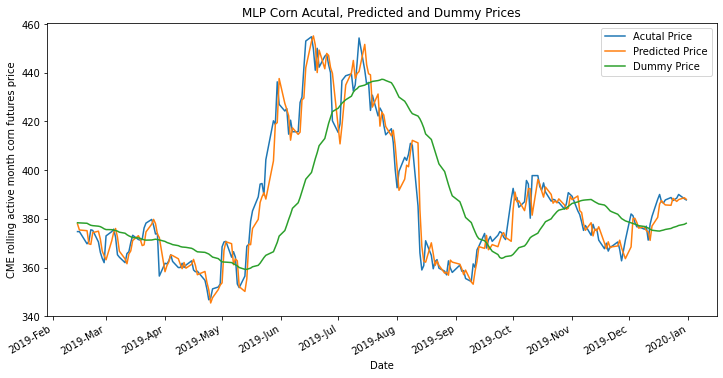

In [22]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

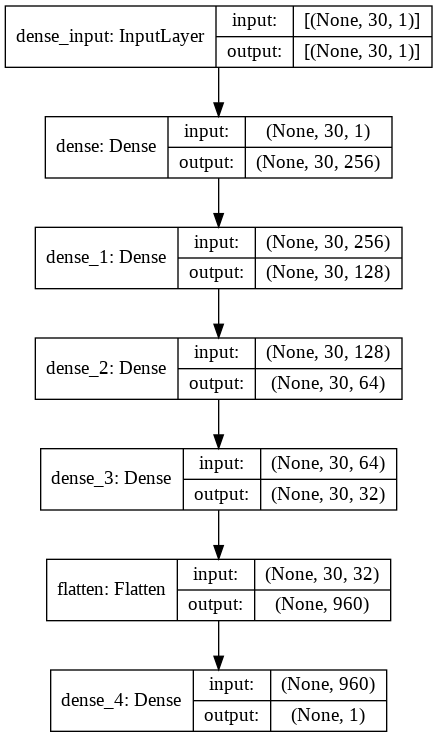

In [23]:
plot_model(model, show_shapes=True, expand_nested=True)

In [24]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.003451637725338372
RMSE:  0.05875064021215745
MAE:  0.041842206929737946
Dummy MSE:  0.041446864361575214
Dummy RMSE:  0.20358502980714277
Dummy MAE:  0.15160472972972977


In [25]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/MLP_Corn/assets
